In this notebook we will use the nn class **Sequential** to model a CNN

We will use the single target network

# Import

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import KFold

from tqdm import tqdm

import load_script
from params import *
from custom_layers import *
from training import *

In [3]:
%load_ext autoreload
%autoreload 2

# Loading the dataset

In [4]:
train_dataset,train_target=load_script.load_dataset_1000hz(train=True)

In [5]:
test_dataset,test_target=load_script.load_dataset_1000hz(train=False)

In [6]:
train_dataset,train_target=load_script.load_dataset(train=True)

In [7]:
test_dataset,test_target=load_script.load_dataset(train=False)

# Normalization

In [8]:
train_dataset.shape

torch.Size([316, 28, 50])

In [9]:
test_dataset.shape

torch.Size([100, 28, 50])

In [10]:
mean=train_dataset.mean(0).view(1,28,50)
std=train_dataset.std(0).view(1,28,50)

In [11]:
train_dataset=(train_dataset-mean)/std
test_dataset=(test_dataset-mean)/std

# Defining the network

### Simple Network

In [12]:
class ThreeLayers(nn.Module):
    
    num_my_conv_layers=3
    num_linear_layers=2
    
    def __init__(self,params):
        super(ThreeLayers,self).__init__()
        
        self.params=params
        
        layers=[]
        for i in range(self.num_my_conv_layers): 
            layers+=MyConv1D(*self.params[i]).layers
        
        layers.append(Flatten())
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.6))
        
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers+1]))
        
        
        self.sequential=nn.Sequential(*layers)
        
    def forward(self,x):
        x=self.sequential(x)
        
        return x

In [51]:
class FullConnect(nn.Module):
    num_my_conv_layers=0
    num_linear_layers=4
    def __init__(self,params):
        super(FullConnect,self).__init__()
        self.dropouts=[0.8,0.8,0.8,0]
        self.params=params
        layers=[]
        layers.append(Flatten())
        for i in range(self.num_linear_layers):
            layers.append(nn.Linear(*self.params[self.num_my_conv_layers+i]))
            layers.append(nn.BatchNorm1d(self.params[self.num_my_conv_layers+i][1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(self.dropouts[i]))
        
        self.sequential=nn.Sequential(*layers)
        
    def forward(self,x):
        x=self.sequential(x)
        
        return x
        

In [13]:
class FullConv(nn.Module):
    num_my_conv_layers=4
    num_linear_layers=0
    def __init__(self,params):
        super(FullConv,self).__init__()
        
        self.params=params
        layers=[]
        for i in range(self.num_my_conv_layers):
            layers+=MyConv1D(*self.params[i]).layers
        
        layers.append(Flatten())
        self.sequential=nn.Sequential(*layers)
        
    def forward(self,x):
        x=self.sequential(x)
        
        return x

# Training

## Full Convolutional training

  0%|          | 1/500 [00:00<00:55,  8.91it/s]

Network:

[28, 28, 3, 1, 5, 0.8, True]
[28, 28, 3, 1, 1, 0.8, True]
[28, 28, 3, 1, 1, 0.8, True]
[1008, 244]
[244, 2]

Repetition 0


100%|██████████| 500/500 [01:01<00:00,  8.11it/s]


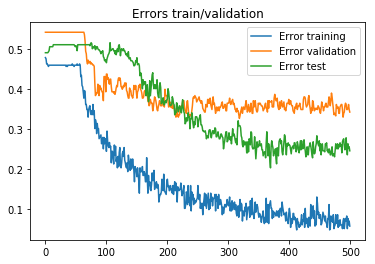

  0%|          | 2/500 [00:00<00:41, 12.03it/s]

Performance train: 0.0755189873418
Performance validation: 0.356911392405
Performance test: 0.25278
Repetition 1


 14%|█▍        | 72/500 [00:09<00:56,  7.58it/s]


KeyboardInterrupt: 

In [23]:
cv=CrossValidation(k=2,train_dataset=train_dataset,test_dataset=test_dataset,
                   train_target=train_target,test_target=test_target)

net_type=FullConv
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
network_params=NetworkParams(conv_filters=[28,14,7,2],conv_kernels=[5,9,11,20],dropout_rate=[0.8,0.8,0,0],\
                             stride=1,dilation=[3,1,1,1])
#network_params=NetworkParams(linear_filters=[244,2],dropout_rate=0.8,dilation=[5,1,1])
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=500,mini_batch_size=2*79)


params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,\
              optimizer_params=optimizer_params,train_params=train_params)

cv(params)

# Train full connnected

In [ ]:
cv=CrossValidation(k=2,train_dataset=train_dataset,test_dataset=test_dataset,
                   train_target=train_target,test_target=test_target)

net_type=FullConnect
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
#network_params=NetworkParams(conv_filters=[28,14,7,2],conv_kernels=[5,9,11,20],dropout_rate=[0.6,0.6,0,0],\
 #                            stride=1,dilation=[3,1,1,1])
network_params=NetworkParams(linear_filters=[50,100,200,2],conv1D=False)
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=1000,mini_batch_size=2*79)


params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,\
              optimizer_params=optimizer_params,train_params=train_params)

cv(params)

  1%|          | 6/1000 [00:00<00:17, 55.64it/s]

FullConnect(
  (sequential): Sequential(
    (0): Flatten(
    )
    (1): Linear(in_features=1400, out_features=50, bias=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
    (3): ReLU()
    (4): Dropout(p=0.8)
    (5): Linear(in_features=50, out_features=100, bias=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True)
    (7): ReLU()
    (8): Dropout(p=0.8)
    (9): Linear(in_features=100, out_features=200, bias=True)
    (10): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU()
    (12): Dropout(p=0.8)
    (13): Linear(in_features=200, out_features=2, bias=True)
    (14): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True)
    (15): ReLU()
    (16): Dropout(p=0)
  )
)
Repetition 0


 13%|█▎        | 126/1000 [00:01<00:12, 70.31it/s]

In [14]:
? nn.Conv1d

In [74]:
list_diego=[1,2,3]
list_rosa=[4,5,6]
fiori=zip(list_diego,list_rosa)
for i in fiori: print(i)

(1, 4)
(2, 5)
(3, 6)


In [71]:
? zip

In [75]:
? nn.Conv2d